## Large Language Model Experiment: Using gpt-3.5-turbo

This experiment evaluates the performance of the gpt-3.5-turbo model on the multiclass aphasia classification task.

Unlike traditional machine learning models that rely on explicit feature engineering or transformer-based classifiers trained end-to-end, gpt-3.5-turbo is used here in a zero-shot or few-shot setting to directly predict aphasia subtypes based on full patient utterances.

 The prompt design was carefully structured to include task-specific instructions and representative examples when applicable. This LLM-based evaluation complements the benchmarking study by offering insight into the capabilities of foundation models on clinical text with limited labeled data and subtle syntactic distinctions.

In [1]:
import pandas as pd
import io
import os
from openai import OpenAI
import pandas as pd
import time
import re
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [1]:
# import data here

In [ ]:
# initialize the OpenAI client
client = OpenAI(api_key= "add your key here")

# define the classification function
def classify_text(text):
    # define the system message
    system_message = {
        "role": "system",
        "content": """You are a clinical text classifier specializing in language and speech characteristics related to Primary Progressive Aphasia (PPA). Based on the provided interview transcript of a patient, classify the text into one of the following categories:

        - **lvPPA**: Logopenic Variant, Characterized by word-finding difficulties and impaired repetition abilities. Patients may frequently pause or hesitate as they search for words, and they may struggle to repeat phrases accurately.
          - **Example**: Patient might say, “I went to the… um… place where… you know, people get… books,” when trying to say "library." They may also struggle to repeat phrases accurately, often omitting words or stumbling.
        - **svPPA**: Semantic Variant, Primarily affects the understanding of word meanings (semantic knowledge). Patients may struggle with naming and comprehension, even for common objects. They often resort to broad categories instead of precise words (e.g., thing instead of fork)
          - **Example**: When shown a picture of a dog, the patient might say, “It’s an animal… I think it’s a pet,” without being able to retrieve the word "dog." They may also have difficulty understanding specific terms, relying on broader descriptions.
        - **nfvPPA**: Impacts grammar and speech production, leading to slow, effortful, and agrammatic speech. Patients may omit small grammatical words (e.g., “is,” “the”) and speak in a telegraphic manner. Patients tend to use very short sentences, a rich vocabulary with low-frequency words, and more nouns compared to verbs.
          - **Example**: The patient might say, “Walk… store… buy milk,” instead of “I’m going to walk to the store to buy milk.” Speech is often halting and labor-intensive, with noticeable pauses.
        - **control**: The individual demonstrates fluent, grammatically correct speech, free from any markers of hesitation, effortful speech, or semantic impairment. There are no indications of word-finding difficulties or grammatical errors. The individual uses both simple and complex sentences naturally and appropriately. They can express themselves clearly without notable pauses, hesitations, or substitutions. The vocabulary used is appropriate for the context, and their language comprehension and responses are cohesive.
          - **Example**: “I’m going to walk to the store to buy some milk” or “After I finish work, I plan to go for a walk and then cook dinner.” The language is fluent, natural, and demonstrates coherent sentence-building abilities.
        Analyze the language, sentence structure, vocabulary, and speech flow within the conversational context of the interview to determine the most fitting category. Your response should include only one of the following labels: **lvPPA**, **svPPA**, **nfvPPA**, or **control**, if the text does not clearly fit into one category, analyze it carefully and suggest the most likely category based on available evidence."""
        }

    # define the user message
    user_message = {"role": "user", "content": text}

    # combine system and user messages into the conversation
    messages = [system_message, user_message]

    # make the API call
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        temperature=0.7  # adjust temperature as needed
    )

    # extract the classification
    classification = response.choices[0].message.content.strip()
    print("Classification:", classification)
    return classification


results = []
for i, text in enumerate(df['Text']):
    classification = classify_text(text)
    results.append(classification)
    time.sleep(20)  # delay to comply with rate limits

# add results to the DataFrame
df['PredictedLabel'] = results

# save the DataFrame
df.to_csv("classified_results_with_delay.csv", index=False)

In [4]:
# define a function to clean up the predictions
def clean_classification(pred):
    # match only the valid classification labels
    match = re.search(r"\b(control|lvPPA|svPPA|nfvPPA)\b", pred, re.IGNORECASE)
    if match:
        return match.group(1)  # return the clean label
    else:
        return "Unclear"  # default for unexpected outputs

# apply the cleaning function to the PredictedLabel column
df['CleanedPredictedLabel'] = df['PredictedLabel'].apply(clean_classification)


In [5]:
df['Subtype'] = df['Subtype'].str.lower()
df['CleanedPredictedLabel'] = df['CleanedPredictedLabel'].str.lower()
true_labels = df['Subtype']  # ground truth labels
predicted_labels = df['CleanedPredictedLabel']  # predicted labels (cleaned)
# verify that labels are consistent
print(true_labels.value_counts())
print(predicted_labels.value_counts())

Subtype
control    53
nfvppa     29
lvppa      26
svppa      24
Name: count, dtype: int64
CleanedPredictedLabel
control    74
nfvppa     47
svppa       8
lvppa       3
Name: count, dtype: int64


In [6]:
balanced_acc = balanced_accuracy_score(true_labels, predicted_labels)

precision = precision_score(true_labels, predicted_labels, average='weighted')

recall = recall_score(true_labels, predicted_labels, average='weighted')

f1 = f1_score(true_labels, predicted_labels, average='weighted')

# confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=['control', 'lvppa', 'svppa', 'nfvppa'])

# print Metrics
print("Balanced Accuracy:", balanced_acc)
print("Precision (weighted):", precision)
print("Recall (weighted):", recall)
print("F1 Score (weighted):", f1)


Balanced Accuracy: 0.3822704485928298
Precision (weighted): 0.4424209025272855
Recall (weighted): 0.5
F1 Score (weighted): 0.42708296795353967


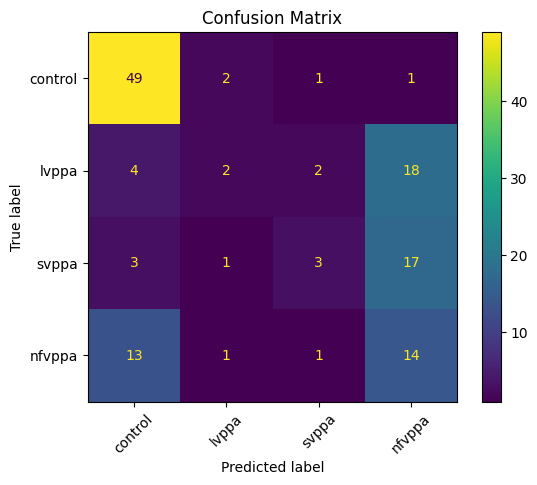

In [32]:

# display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['control', 'lvppa', 'svppa', 'nfvppa'])
disp.plot(cmap='viridis', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()
